# Book Recommendation Dataset: EDA & preparation 

Sources:
- dataset paper: [Ziegler, Cai-Nicolas, et al. "Improving recommendation lists through topic diversification."](https://dl.acm.org/doi/pdf/10.1145/1060745.1060754)
- [dataset kaggle](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data)

In [1]:
import os

import matplotlib.pyplot as plt
import missingno as mn
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2
from pandas import DataFrame

In [2]:
og_ds_path = "./og-dataset"
new_ds_path = "./book-feedback.csv"

In [3]:
books_df = pd.read_csv(filepath_or_buffer=os.path.join(og_ds_path, "Books.csv"))
ratings_df = pd.read_csv(filepath_or_buffer=os.path.join(og_ds_path, "Ratings.csv"))
users_df = pd.read_csv(filepath_or_buffer=os.path.join(og_ds_path, "Users.csv"))

/tmp/ipykernel_17197/2078345232.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv(filepath_or_buffer=os.path.join(og_ds_path, "Books.csv"))


## Basic info

In [4]:
books_df.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271358,271360,271358,271360,271360,271357
unique,271360,242135,102022,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,13903,7535,2,2,2


In [5]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [6]:
ratings_df.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [7]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [8]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [9]:
users_df.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [10]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


## Missing values & errors

In [11]:
def missing(df: DataFrame):
    print(df.isnull().sum())
    print(df[df.isnull().any(axis=1)])

for df in [books_df, ratings_df, users_df]:
    missing(df)
    print("="*40)

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64
              ISBN                                         Book-Title  \
118033  0751352497                           A+ Quiz Masters:01 Earth   
128890  193169656X                                        Tyrant Moon   
129037  1931696993                                    Finders Keepers   
187689  9627982032  The Credit Suisse Guide to Managing Your Perso...   
209538  078946697X  DK Readers: Creating the X-Men, How It All Beg...   
220731  2070426769  Peuple du ciel, suivi de 'Les Bergers\";Jean-M...   
221678  0789466953  DK Readers: Creating the X-Men, How Comic Book...   

            Book-Author Year-Of-Publication  \
118033              NaN                1999   
128890  Elaine Corvidae                2002   
129037  Linnea Sinclair                2001   
187689        

In [12]:
# bacause of time constraints image data will not be used
# only few null values, no need for something complex
books_df.drop(["Image-URL-S", "Image-URL-M", "Image-URL-L"], axis=1, inplace=True)
books_df["Book-Author"].fillna("", inplace=True)
books_df["Publisher"].fillna("", inplace=True)


In [13]:
joined_df = pd.merge(books_df, ratings_df, on='ISBN', how='inner')
joined_df = pd.merge(joined_df, users_df, on='User-ID', how='inner')

joined_df.shape, ratings_df.shape, books_df.shape, users_df.shape

((1031136, 9), (1149780, 3), (271360, 5), (278858, 3))

<Axes: >

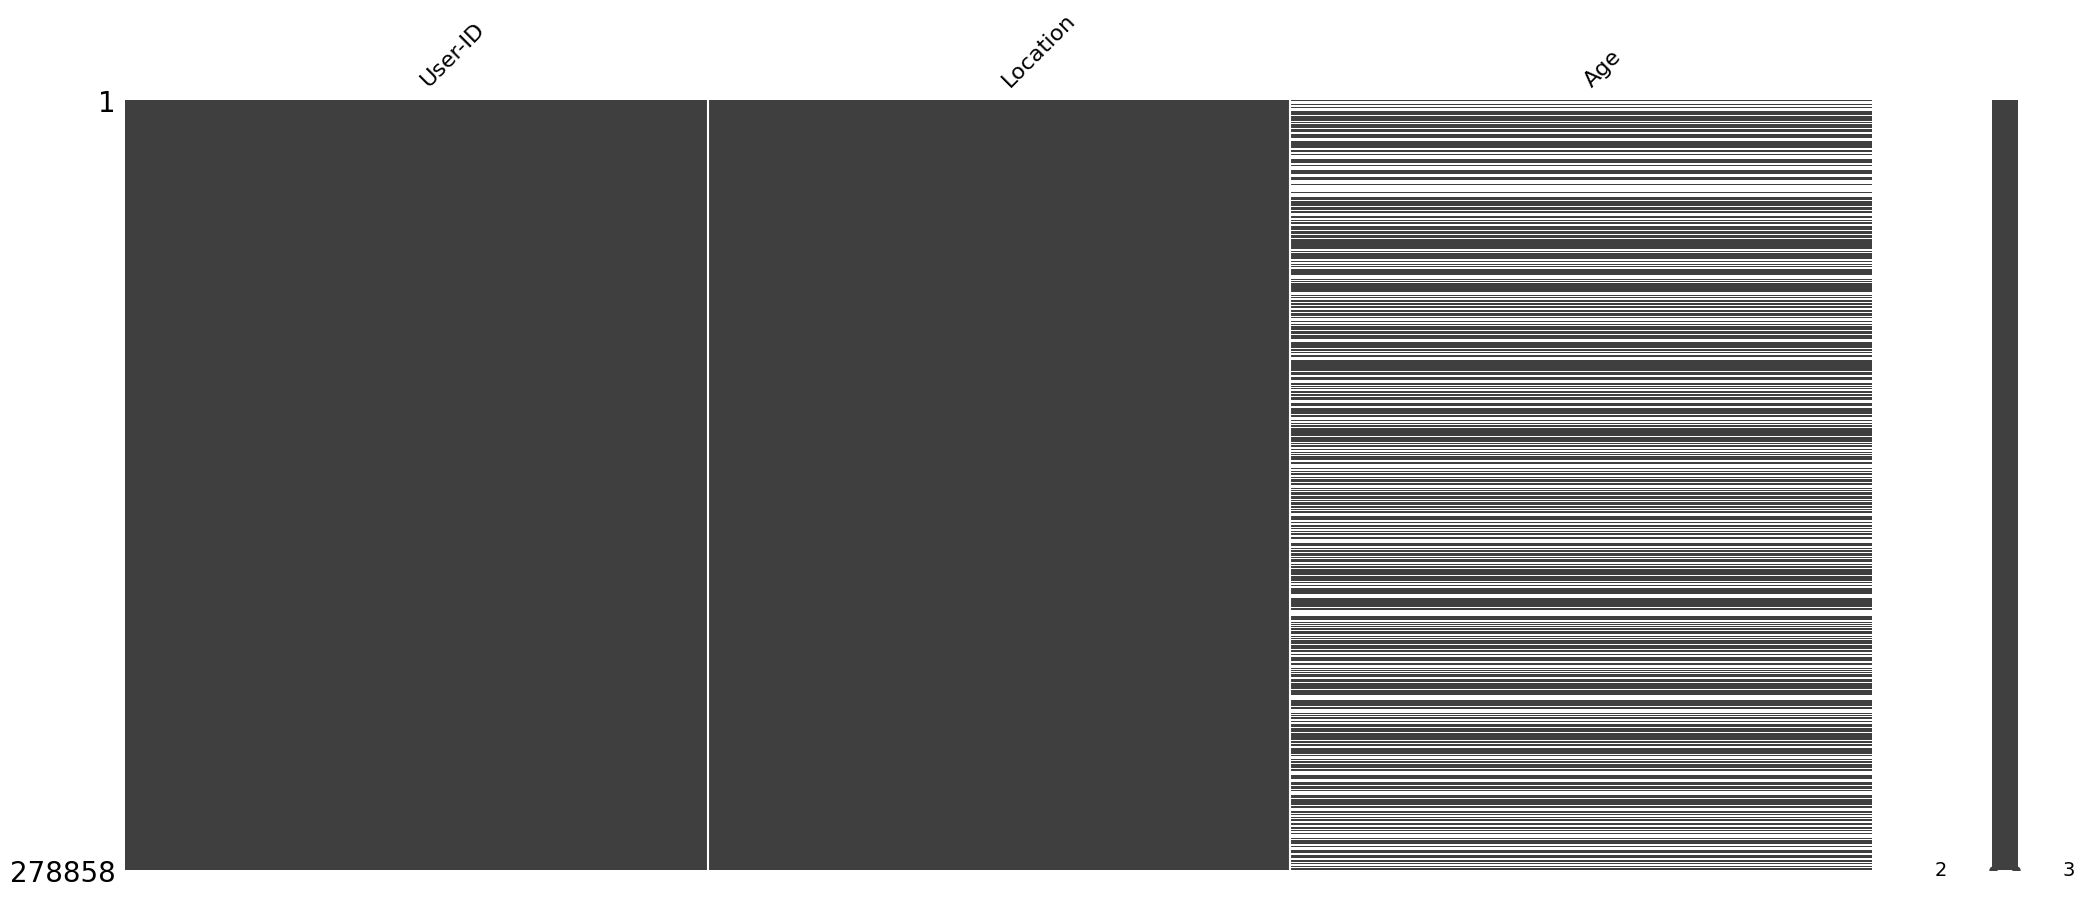

In [14]:
mn.matrix(users_df)

In [15]:
error_rows = []

for index, value in enumerate(books_df['Year-Of-Publication']):
    try:
        books_df.at[index, 'Year-Of-Publication'] = int(value)
    except (ValueError, TypeError):
        error_rows.append(index)
wrong = books_df.iloc[error_rows]
wrong

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [16]:
for idx in error_rows:
    book_title, author = books_df.iloc[idx]["Book-Title"].split(";")
    publisher = books_df.iloc[idx]["Year-Of-Publication"]
    year = books_df.iloc[idx]["Book-Author"]

    books_df.iloc[idx]["Book-Title"] = book_title
    books_df.iloc[idx]["Book-Author"] = author
    books_df.iloc[idx]["Year-Of-Publication"] = year

In [17]:
books_df.iloc[error_rows]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...","Michael Teitelbaum""",2000,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\""","Jean-Marie Gustave Le ClÃ?Â©zio""",2003,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...","James Buckley""",2000,http://images.amazon.com/images/P/0789466953.0...


## Counts and dist

In [18]:
ratings_df["ISBN"].nunique(), books_df["ISBN"].nunique()

(340556, 271360)

In [19]:
rated_books = pd.merge(books_df, ratings_df, on="ISBN")
rated_books.shape, rated_books["ISBN"].nunique()

((1031136, 7), 270151)

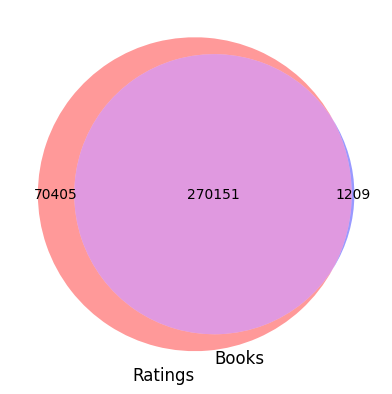

In [20]:
# there are ratings for books which are not in book table
ratings_set = set(ratings_df["ISBN"])
books_set = set(books_df["ISBN"])

venn2(subsets=(len(ratings_set - books_set), len(books_set - ratings_set), len(ratings_set & books_set)),
      set_labels=("Ratings", "Books"),
      set_colors=("red", "blue"))

plt.show()

In [21]:
num_isbns = 70405+270151

In [22]:
# drop books without ratings
merged_books_df = books_df.merge(ratings_df, on='ISBN', how='left')

books_without_rating = merged_books_df[merged_books_df['Book-Rating'].isna()]

books_df = books_df[~books_df['ISBN'].isin(books_without_rating['ISBN'])]

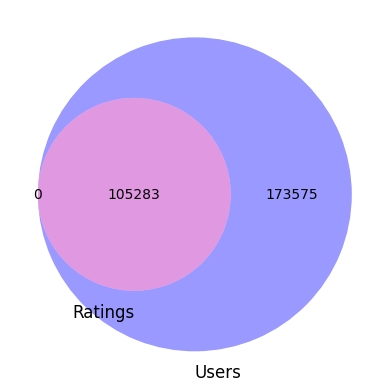

In [23]:
ratings_set = set(ratings_df["User-ID"])
users_set = set(users_df["User-ID"])

venn2(subsets=(len(ratings_set - users_set), len(users_set - ratings_set), len(ratings_set & users_set)),
      set_labels=("Ratings", "Users"),
      set_colors=("red", "blue"))

plt.show()

In [24]:
# drop users without ratings
merged_df = users_df.merge(right=ratings_df, on='User-ID', how='left')

users_without_rating = merged_df[merged_df['Book-Rating'].isna()]

print("Users without a rating:")
print(users_without_rating[['User-ID']].shape)

Users without a rating:
(173575, 1)


In [25]:
users_without_rating.head()

,User-ID,Location,Age,ISBN,Book-Rating
0,1,"nyc, new york, usa",NaN,NaN,NaN
2,3,"moscow, yukon territory, russia",NaN,NaN,NaN
3,4,"porto, v.n.gaia, portugal",17.0,NaN,NaN
4,5,"farnborough, hants, united kingdom",NaN,NaN,NaN
5,6,"santa monica, california, usa",61.0,NaN,NaN


In [26]:
users_df = users_df[~users_df['User-ID'].isin(users_without_rating['User-ID'])]

In [27]:
res = ratings_df[ratings_df['User-ID'] == 1]
res

,User-ID,ISBN,Book-Rating


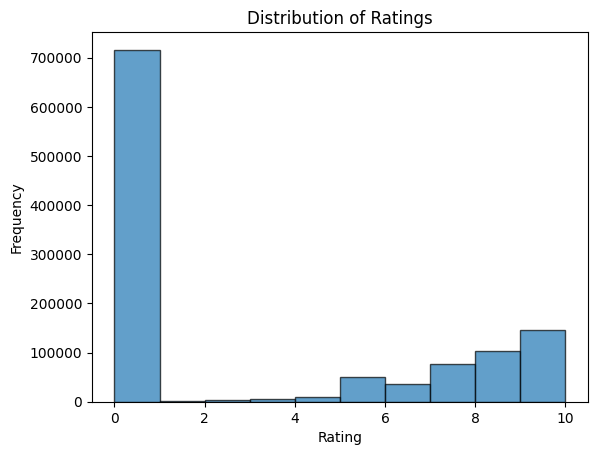

In [28]:
plt.hist(ratings_df['Book-Rating'], bins=10, edgecolor='black', alpha=0.7)

plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.show()

- rating 0 means implicit feedback. What does it mean?
- excerpt from the original paper
  - "Ratings can either be explicit, i.e., by
having the user state his opinion about a given product, or
implicit, when the mere act of purchasing or mentioning of
an item counts as an expression of appreciation. While implicit ratings are generally more facile to collect, their usage
implies adding noise to the collected information "
  - Data Collection
    - In a 4-week crawl, we collected data on 278, 858 members
of BookCrossing and 1, 157, 112 ratings, both implicit and
explicit, referring to 271, 379 distinct ISBNs 
- ok :)

In [29]:
books_df.columns, books_df.shape

(Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
        'Publisher'],
       dtype='object'),
 (270151, 5))

In [30]:
books_df["Book-Title"].value_counts()

Book-Title
Selected Poems                                                                                                                    26
Little Women                                                                                                                      24
Wuthering Heights                                                                                                                 21
Dracula                                                                                                                           20
Adventures of Huckleberry Finn                                                                                                    20
                                                                                                                                  ..
Worry: Controlling It and Using It Wisely                                                                                          1
An Encounter With a Prophet                               

In [31]:
books_df["Book-Author"].value_counts()

Book-Author
Agatha Christie        631
William Shakespeare    564
Stephen King           522
Ann M. Martin          420
Carolyn Keene          372
                      ... 
Diana Wakeman            1
Jayne Gurley             1
Madeline Sunshine        1
Claudia Ponte            1
Christopher  Biffle      1
Name: count, Length: 101589, dtype: int64

In [32]:
books_df["Year-Of-Publication"].value_counts(), books_df["Year-Of-Publication"].astype(int).sort_values().unique()

(Year-Of-Publication
 2002    17543
 1999    17342
 2001    17265
 2000    17151
 1998    15700
         ...  
 2038        1
 1910        1
 1914        1
 1904        1
 2037        1
 Name: count, Length: 118, dtype: int64,
 array([   0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908,
        1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924,
        1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
        1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
        1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
        1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
        1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
        1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
        1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
        2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021,
        2024, 2026, 2030, 2037, 2

In [33]:
users_df.columns, users_df.shape

(Index(['User-ID', 'Location', 'Age'], dtype='object'), (105283, 3))

In [34]:
# there were some really old people xd
users_df["Age"].value_counts(), users_df["Age"].dropna().sort_values().unique()

(Age
 26.0     1970
 29.0     1959
 25.0     1953
 28.0     1890
 27.0     1879
          ... 
 147.0       1
 97.0        1
 168.0       1
 132.0       1
 98.0        1
 Name: count, Length: 144, dtype: int64,
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  89.,
         90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
        101., 103., 104., 105., 107., 108., 109., 114., 115., 116., 118.,
        123., 124., 127., 128., 132., 133., 136.,

In [35]:
ratings_df['User-ID'].value_counts()

User-ID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: count, Length: 105283, dtype: int64

## Aggregate into one row
- in one row information about user and book for simpler processing of models

In [36]:
ratings_df.shape

(1149780, 3)

In [37]:
ratings_df["ISBN"].nunique()

340556

In [38]:
ratings = ratings_df.merge(books_df, how="left", on="ISBN")
ratings.shape

(1149780, 7)

In [39]:
ratings = ratings.merge(users_df, how="inner", on="User-ID")
ratings.shape

(1149780, 9)

In [40]:
ratings[ratings["Book-Title"] == "Why Didn't They Ask Evans?"]

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age
6143,278418,0425098559,0,Why Didn't They Ask Evans?,Agatha Christie,1992,Berkley Publishing Group,"omaha, nebraska, usa",NaN
72721,15418,0425098559,0,Why Didn't They Ask Evans?,Agatha Christie,1992,Berkley Publishing Group,"vitoria, álava, spain",23.0
213805,49889,0440107040,10,Why Didn't They Ask Evans?,Agatha Christie,1982,Bantam Books (Mm),"orem, utah, usa",NaN
399453,95991,0425098559,6,Why Didn't They Ask Evans?,Agatha Christie,1992,Berkley Publishing Group,"santa ana, california, usa",28.0
601771,145449,0425098559,0,Why Didn't They Ask Evans?,Agatha Christie,1992,Berkley Publishing Group,"virginia beach, virginia, usa",NaN
722233,174726,0425098559,0,Why Didn't They Ask Evans?,Agatha Christie,1992,Berkley Publishing Group,"san diego, california, usa",NaN
726791,175312,0425098559,7,Why Didn't They Ask Evans?,Agatha Christie,1992,Berkley Publishing Group,"ottawa, ontario, canada",16.0
765615,185233,0440107040,0,Why Didn't They Ask Evans?,Agatha Christie,1982,Bantam Books (Mm),"winnemucca, nevada, usa",31.0
793215,191716,0425098559,0,Why Didn't They Ask Evans?,Agatha Christie,1992,Berkley Publishing Group,"tatamagouche, nova scotia, canada",49.0
803509,195287,0425098559,7,Why Didn't They Ask Evans?,Agatha Christie,1992,Berkley Publishing Group,"vitoria, alava, spain",NaN


In [41]:
user_id_mapping = {user_id: index for index, user_id in enumerate(ratings['User-ID'].unique())}
ratings.loc[:, 'user_id'] = ratings['User-ID'].map(user_id_mapping)

book_id_mapping = {book_id: index for index, book_id in enumerate(ratings['ISBN'].unique())}
ratings.loc[:, 'book_id'] = ratings['ISBN'].map(book_id_mapping)

In [42]:
ratings.describe()

,User-ID,Book-Rating,Age,user_id,book_id
count,1.149780e+06,1.149780e+06,840288.000000,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00,37.239724,5.295677e+04,8.876410e+04
std,8.056228e+04,3.854184e+00,14.246676,3.039397e+04,9.191268e+04
min,2.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00,28.000000,2.697700e+04,1.517900e+04
50%,1.410100e+05,0.000000e+00,35.000000,5.320200e+04,5.077200e+04
75%,2.110280e+05,7.000000e+00,45.000000,7.937400e+04,1.415450e+05
max,2.788540e+05,1.000000e+01,244.000000,1.052820e+05,3.405550e+05


In [43]:
ratings_df["ISBN"].nunique(), ratings_df.shape

(340556, (1149780, 3))

In [44]:
users_df["User-ID"].nunique(), users_df.shape

(105283, (105283, 3))

In [45]:
ratings["book_id"].nunique(), ratings["user_id"].nunique(), ratings["ISBN"].nunique()

(340556, 105283, 340556)

In [46]:
ratings.shape

(1149780, 11)

In [47]:
ratings.drop(["User-ID"], axis=1, inplace=True)
ratings.drop(["ISBN"], axis=1, inplace=True)

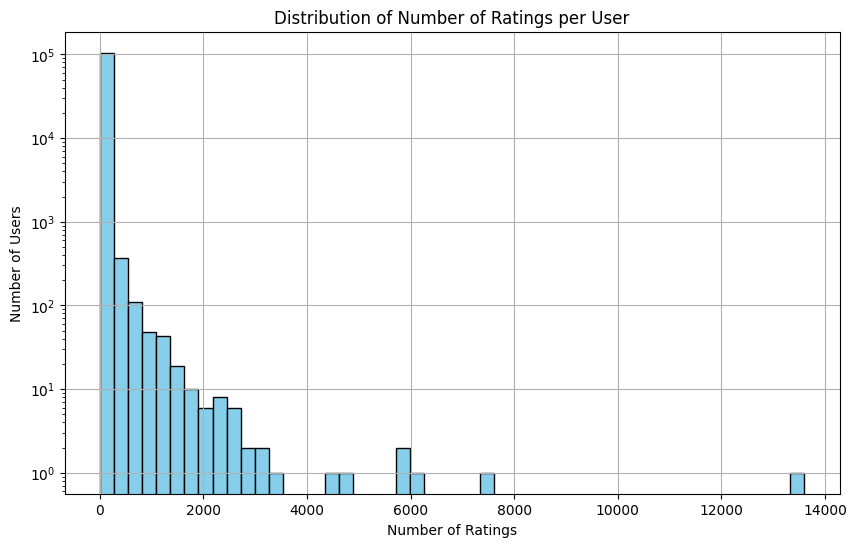

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(ratings['user_id'].value_counts(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.yscale('log')
plt.grid(True)
plt.show()

- drop users with less than 10 ratings

In [49]:
user_ratings_counts = ratings['user_id'].value_counts()

users_with_less_than_10_ratings = user_ratings_counts[user_ratings_counts < 10].index
ratings = ratings[~ratings['user_id'].isin(users_with_less_than_10_ratings)]


ratings.shape, ratings["user_id"].nunique()

((965713, 9), 13097)

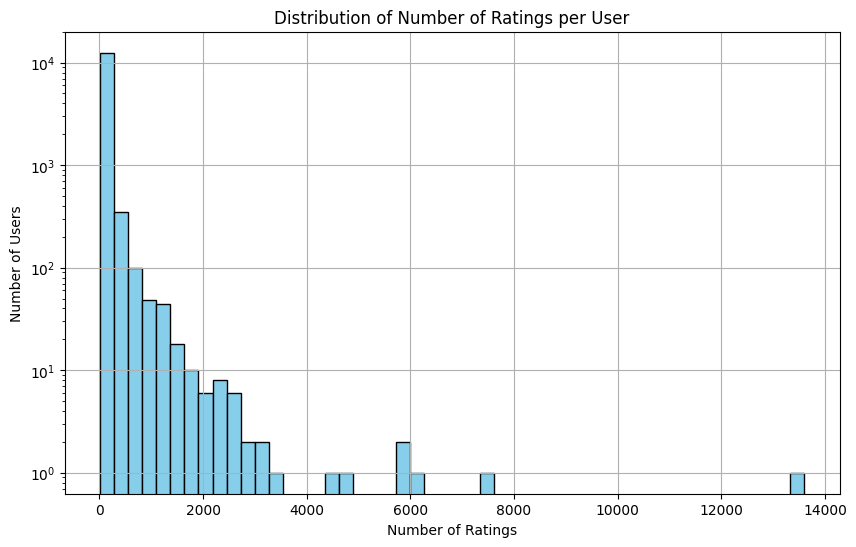

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(ratings['user_id'].value_counts(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.yscale('log')
plt.grid(True)
plt.show()

In [51]:
ratings['user_id'].value_counts()

user_id
5063     13602
75665     7550
58963     6109
38206     5891
14426     5850
         ...  
62764       10
53653       10
74814       10
43870       10
86331       10
Name: count, Length: 13097, dtype: int64

(array([5078.,  133.,  112.,  217.,  294.,  835.,  873., 1597., 2138.,
        2325.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

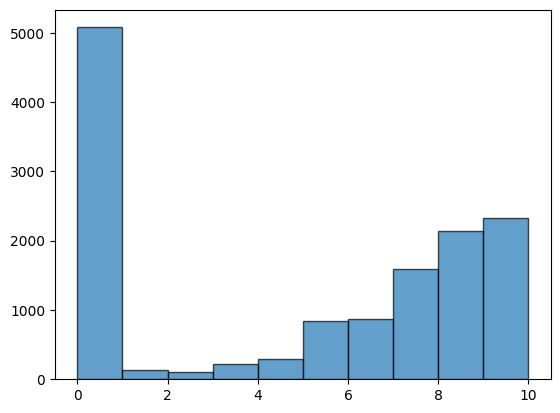

In [52]:
plt.hist(ratings[ratings["user_id"] == 5063]['Book-Rating'], bins=10, edgecolor='black', alpha=0.7)

In [53]:
ratings[ratings["user_id"] == 5063].head(1)

,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age,user_id,book_id
45326,7,NaN,NaN,NaN,NaN,"n/a, n/a, n/a",NaN,5063,33488


(array([7.533e+03, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 8.000e+00, 3.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

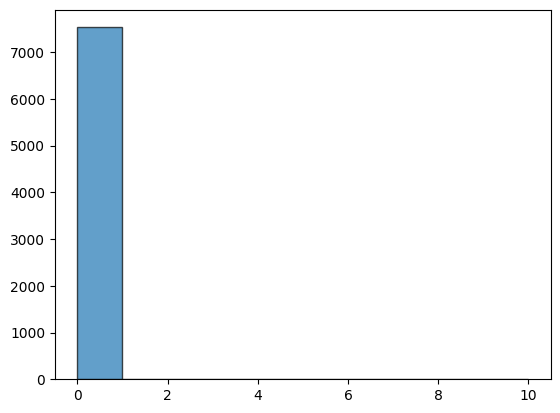

In [54]:
plt.hist(ratings[ratings["user_id"] == 75665]['Book-Rating'], bins=10, edgecolor='black', alpha=0.7)

In [55]:
ratings[ratings["user_id"] == 75665].head(1)

,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age,user_id,book_id
816071,0,Paddington's Birthday Party,Michael Bond,1942,HarperCollins Publishers,"little canada, minnesota, usa",62.0,75665,277627


In [56]:
ratings["Book-Rating"].value_counts()

Book-Rating
0     639906
8      76482
10     62738
7      55752
9      52640
5      38472
6      26522
4       6078
3       4011
2       1881
1       1231
Name: count, dtype: int64

In [57]:
ratings["Age"] = ratings["Age"].fillna(-1).astype(int)

In [58]:
ratings["Age"].value_counts().sort_index()

Age
-1      236909
 0         713
 1         387
 2         251
 3         166
         ...  
 220        15
 228        65
 229        11
 239       119
 244        28
Name: count, Length: 113, dtype: int64

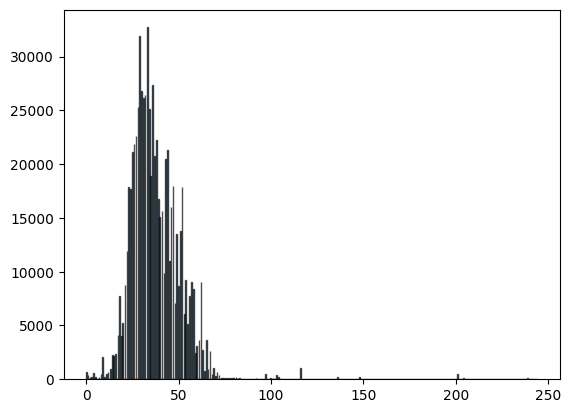

In [59]:
plt.hist(ratings[ratings["Age"] != -1]["Age"], bins="auto", edgecolor='black', alpha=0.7)
plt.show()

In [60]:
ratings[ratings["Age"] > 123].shape[0]

1399

In [61]:
ratings.isna().sum()

Book-Rating                0
Book-Title             88584
Book-Author            88584
Year-Of-Publication    88584
Publisher              88584
Location                   0
Age                        0
user_id                    0
book_id                    0
dtype: int64

In [62]:
for n in ["Book-Title", "Book-Author", "Publisher"]:
    ratings[n] = ratings[n].fillna("")

In [63]:
ratings["Year-Of-Publication"] = ratings["Year-Of-Publication"].fillna(-1)

In [64]:
ratings.isna().sum()

Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Location               0
Age                    0
user_id                0
book_id                0
dtype: int64

## Save

In [65]:
ratings

,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age,user_id,book_id
31,0,Southampton Row (Charlotte &amp; Thomas Pitt N...,Anne Perry,2002,Ballantine Books,"duisburg, nordrhein-westfalen, germany",25,16,31
32,0,CLOUT,D. GIBBONS,2024,Avon,"duisburg, nordrhein-westfalen, germany",25,16,32
33,5,See Jane Run,Joy Fielding,1992,Avon,"duisburg, nordrhein-westfalen, germany",25,16,33
34,0,The Dark Half,Stephen King,1994,Signet Book,"duisburg, nordrhein-westfalen, germany",25,16,34
35,0,House of the Sun (Shadowrun),Fanpro,2003,Fanpro,"duisburg, nordrhein-westfalen, germany",25,16,35
...,...,...,...,...,...,...,...,...,...
1149771,7,Dreamcatcher,Stephen King,2001,Scribner,"cedar park, texas, usa",-1,105278,8851
1149772,0,All I Really Need to Know,ROBERT FULGHUM,1989,Ivy Books,"cedar park, texas, usa",-1,105278,2104
1149773,5,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997,Sterling Publishing,"cedar park, texas, usa",-1,105278,340554
1149774,0,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998,A.R.E. Press (Association of Research &amp; Enlig,"cedar park, texas, usa",-1,105278,284681


In [66]:
ratings.columns

Index(['Book-Rating', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Publisher', 'Location', 'Age', 'user_id', 'book_id'],
      dtype='object')

In [67]:
duplicate_pairs = ratings.duplicated(subset=['book_id', 'user_id'], keep=False)
# duplicate_pairs = ratings.duplicated(subset=['User-ID', 'ISBN'], keep=False)

print("Rows with duplicate book_id and user_id pairs:")
print(ratings[duplicate_pairs])

Rows with duplicate book_id and user_id pairs:
Empty DataFrame
Columns: [Book-Rating, Book-Title, Book-Author, Year-Of-Publication, Publisher, Location, Age, user_id, book_id]
Index: []


In [68]:
ratings.to_csv(path_or_buf=new_ds_path)

## Notes on final ds
- missing Age -> -1
- missing Year of publication -> -1
- not all ratings have Book data